# Load Libraries

In [43]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hsi_classification as hc

# Scripts associated with the SML4SI textbook
#!pip3 install --upgrade hyperspectral_gta_data
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2
hsi_data.set_data_dir('../spectral_images')

#Lazy predict
#!pip3 install ./lazypredict #install from cloned github repo as they didn't push spar -> sparse_output update
from lazypredict.Supervised import LazyClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load Data

In [45]:
hsi_data.download('MicroscenePolymers')
fname = hsi_data.get_fname('MicroscenePolymers')

Available Files:
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/spectral_images/spectral_images/Microscene_Polymers/.DS_Store
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/spectral_images/spectral_images/Microscene_Polymers/reflectance_image_polymers
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/spectral_images/spectral_images/Microscene_Polymers/reflectance_image_polymers.hdr
Primary Image Filename:
../spectral_images/spectral_images/Microscene_Polymers/reflectance_image_polymers


In [46]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
print(im.shape)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')

(852, 384, 452)
Shape of Im.Arr = (852, 384, 452)
Shape of im.List = (327168, 452)


In [47]:
# load the associated ground truth image
fname_gt = '../spectral_images/ground_truth_images/reflectance_image_polymers_surfaces.txt'

file1 = open(fname_gt, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    #print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    #print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    #print(f'Number of points: {len(locations)}')
    #print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))

In [48]:
# Assemble X and Y for training
nSpec = im.List.shape[0] #327168
X = im.List #(327168, 452)
Y_labels = np.unique(gt_list) #list of unique labels
#nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int) #327168
for i in range(nSpec):
    Y[i] = np.where(Y_labels == gt_list[i])[0]

# Plots

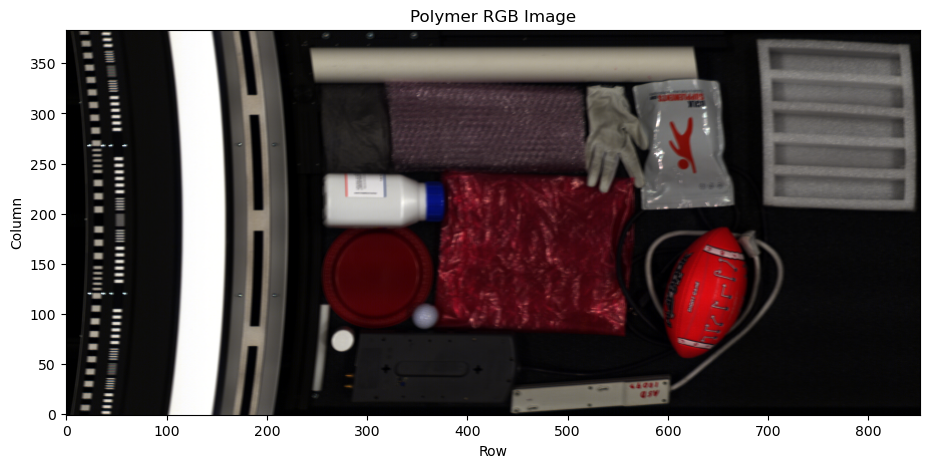

In [50]:
# RGB Image
sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('Polymer RGB Image')
plt.savefig('output/polymer_rgb.png') 
plt.show()

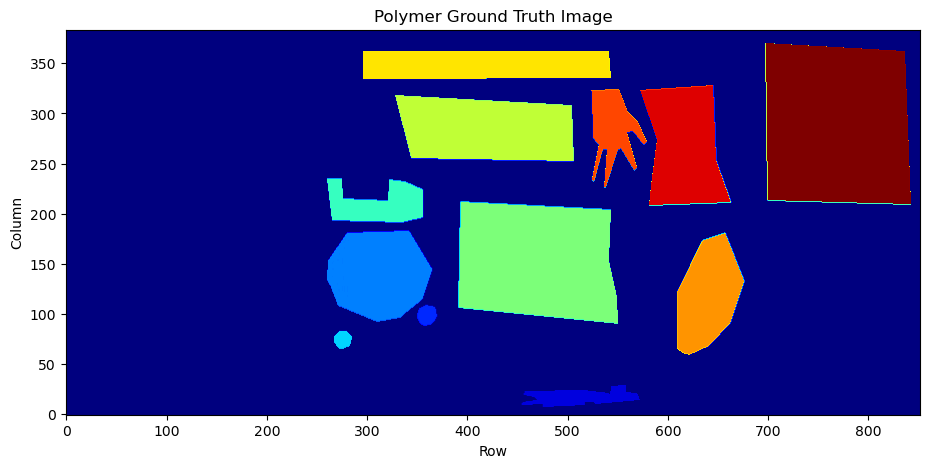

In [51]:
# Ground Truth Image
plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet')
plt.gca().invert_yaxis()  
plt.xlabel('Row')
plt.ylabel('Column')
plt.title('Polymer Ground Truth Image')
plt.savefig('output/polymer_groundtruth.png') 
plt.show()

# 80/20 Split

In [53]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) # 80% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(261734, 452) 0.7999987773865415
(65434, 452) 0.20000122261345854


### Lazy Classifier

### Sklearn LDA

In [56]:
#Scikit-Learn LDA - need to exclude background class 0!!!
clf = LinearDiscriminantAnalysis()
models = clf.fit(X_train, Y_train)
y_pred = models.predict(X_test)
#print(y_pred)

#Evaluation
y_true = Y_test[np.where(Y_test>0)[0]] #Y_train
#print(y_true.shape)
y_pred = y_pred[np.where(Y_test>0)[0]] #Y_pred
#print(y_pred.shape)

y_pred = [x - 1 for x in y_pred]
y_true = y_true - 1
y_true = (y_true).astype(int)

acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.9940877873992237
Balanced Accuracy: 0.9931462601475526
F1 Score: 0.996901664958417


### LDA

In [58]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test!!!!!

nClasses = len(groundtruth_classes.keys())
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    if idx > 0: 
        class_locations = np.where(Y_train==idx)[0] #Y_train
        num_class_spectra = len(class_locations)
        class_spectra = X_train[class_locations,:] #X_train
        class_means[idx-1,:] = np.mean(class_spectra, axis=0)
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) 
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(Y_train>0) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, X_test.T).T #X_test!!!!!
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.9998208420424007
Balanced Accuracy: 0.9985912158557405
F1 Score: 0.9998206086399678


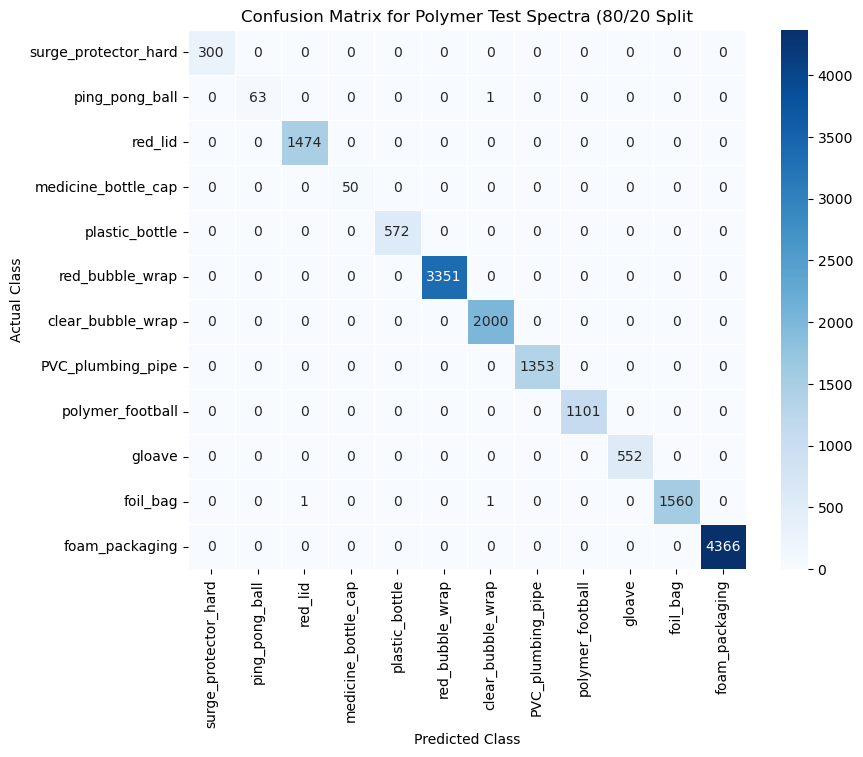

In [60]:
class_names = groundtruth_classes.keys()

y_true = Y_test[np.where(Y_test>0)[0]]
y_pred = LDA_class_list[np.where(Y_test>0)[0]]

# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for Polymer Test Spectra (80/20 Split')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, class_names)
plt.savefig('output/polymer_80_20_confusionMatrix.png')

# 60/40 Split

In [62]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y) # 80% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(196300, 452) 0.5999975547730829
(130868, 452) 0.4000024452269171


### Lazy Classifier

### Sklearn LDA

In [65]:
#Scikit-Learn LDA - need to exclude background class 0!!!
clf = LinearDiscriminantAnalysis()
models = clf.fit(X_train, Y_train)
y_pred = models.predict(X_test)
#print(y_pred)

#Evaluation
y_true = Y_test[np.where(Y_test>0)[0]] #Y_train
#print(y_true.shape)
y_pred = y_pred[np.where(Y_test>0)[0]] #Y_pred
#print(y_pred.shape)

y_pred = [x - 1 for x in y_pred]
y_true = y_true - 1
y_true = (y_true).astype(int)

acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.994505822633622
Balanced Accuracy: 0.9942744620154015
F1 Score: 0.9971289893619948


### LDA

In [67]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test!!!!!!!!!!

nClasses = len(groundtruth_classes.keys())
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    if idx > 0: 
        class_locations = np.where(Y_train==idx)[0] #Y_train
        num_class_spectra = len(class_locations)
        class_spectra = X_train[class_locations,:] #X_train
        class_means[idx-1,:] = np.mean(class_spectra, axis=0)
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) 
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(Y_train>0) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, X_test.T).T #X_test!!!!!!!!!!
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.9998805613616005
Balanced Accuracy: 0.9992577292667368
F1 Score: 0.9998805091823296


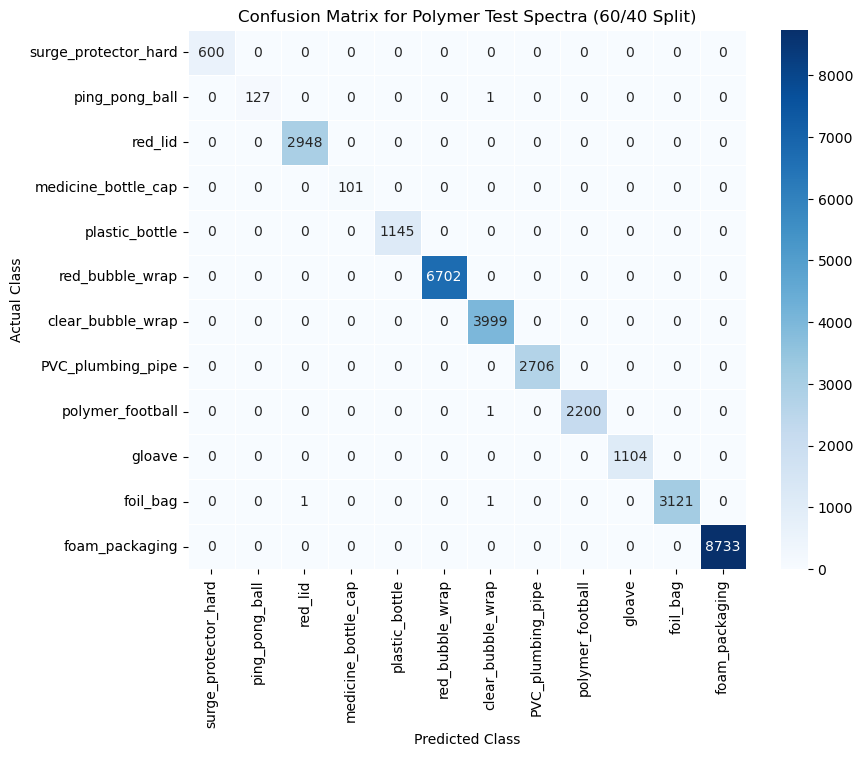

In [69]:
class_names = groundtruth_classes.keys()

y_true = Y_test[np.where(Y_test>0)[0]]
y_pred = LDA_class_list[np.where(Y_test>0)[0]]

# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for Polymer Test Spectra (60/40 Split)')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, class_names)
plt.savefig('output/polymer_60_40_confusionMatrix.png')